In [9]:
import os
import pandas as pd
import numpy as np
from models.recurrent import Recurrent
from keras.layers import LSTM

In [10]:
datapath = os.path.join("data", "crimes_district.csv")
dataset = pd.read_csv(datapath, index_col=["Date", "District"],
                      dtype={"crimes_district_total": np.float32},
                      parse_dates=["Date"])

## Implementation

### The `Recurrent` class

* Convenient interface for all our models

Epoch 1/1
125016/125016 [==============================] - 198s 2ms/step - loss: 5.8031e-04


(<Figure size 720x1440 with 24 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f91735fbd68>,
       dtype=object))

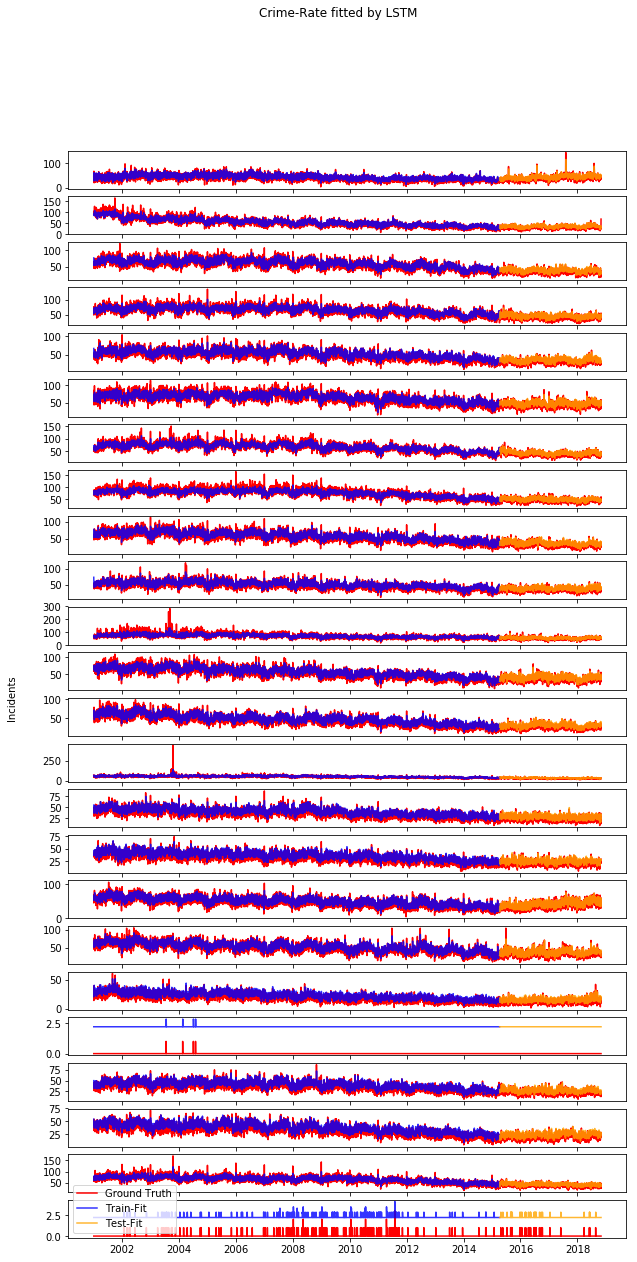

In [11]:
lstm = Recurrent(dataset, 2, cell=LSTM, epochs=1)
lstm.train()
lstm.plot_fit(os.path.join("models", "lstm-district-show-case.png"),
              figsize=(10, 20))


The life-cycle consists of:
1. instantiation
2. training
3. prediction
3. visual analysis

### 1. \_\_init\_\_

* prepare all necessary attributes in `__stage()`
* call


```python
class Recurrent(Sequential):
    def __init__(...):
        # save attributes
        ...
        self.X_train, self.X_test, self.y_train, self.y_test = self.__stage()
        # run parent-class' constructor
        super().__init__()
```

#### 1.1 __stage()

* scale

```python
def __stage(self):
    # Separate train and test data
    ...
    
    self.scaler = MinMaxScaler()
    self.scaler.fit(train.values)
    self.data.loc[:, "y"] = self.scaler.transform(self.data.values)
    ...
    X, y = self.__get_features()
```

#### 1.1.1 \_\_get_features()

* construct features

```python
def __get_features(self):
        """
        Create lagged variables in `self.data`.

        * Returns:
            * (X, y): `numpy.ndarray`s of feature and target values.
        """
        cols = ["lag_" + str(i) for i in range(1, self.maxlag+1)]

        for i, colname in enumerate(cols, 1):
            if isinstance(self.data.index, pd.core.index.MultiIndex):
                lag = self.data.groupby(self.cross_label)["y"].shift(i)
            else:
                lag = self.data["y"].shift(i)

            self.data[colname] = lag

        self.data = self.data.dropna(axis=0)

        # Split into target and features
        y = self.data.iloc[:, 1]
        X = self.data.iloc[:, 2:]

        return X, y
```

### 2. train()

```python
def train(self):
    self.add(self.cell(self.cell_neurons,
                           input_shape=(1, self.maxlag),
                           **self.cellkwargs))
    self.add(Dense(1))
    self.add(Activation('relu'))

    self.compile(loss=self.lossfunc,
                 optimizer=self.optimizer)
    self.fit(X_train, self.y_train,
             epochs=self.epochs,
             batch_size=self.batch_size,
             verbose=self.verbose,
             **self.fitkwargs)
```

### 3. forecast()

* predict test data or completely new data.

```python
def forecast(self, X):
        if X.shape[1] == self.maxlag:
            X_ = self.__transform_shape(X)
            return self.predict(X_)

        else:
            X_, _ = self.__get_features(X)
            return self.predict(X_.values)
```